# Simulating Background ELG Redshifts

This code is bugged, for an updated version look at spec_lens.ipynb

## Imports

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG

import redrock.templates
import redrock.results
from redrock.external import desi
 
from desi_myfunctions import *

%matplotlib inline

In [2]:
import numpy as np

from redrock import zwarning


class PlotSpec(object):
    def __init__(self, targets, templates, zscan, zfit, truth=None, archetypes=False):
        """TODO: document
        """

        #- Isolate imports of optional dependencies
        import matplotlib.pyplot as plt

        #- Only keep targets that are in the zfit table
        keeptargets = list()
        keepids = set(zfit['targetid'])
        for t in targets:
            if t.id in keepids:
                keeptargets.append(t)

        self.targets = keeptargets
        self.templates = templates
        self.archetypes = archetypes
        self.zscan = zscan
        self.zfit = zfit
        self.itarget = 0
        self.znum = 0
        self.smooth = 1
        self.truth = truth
        self.targetid_to_itarget = {}
        for i, t in enumerate(self.targets):
            self.targetid_to_itarget[t.id] = i

        ################################################################            
        # I adjusted the plot size by adding figsize, 
        # to revert back to the original size uncomment code below
    
        self._fig = plt.figure(figsize=(16,8))
        
        ################################################################
        #self._fig = plt.figure()
        self._ax1 = self._fig.add_subplot(211)
        self._ax2 = self._fig.add_subplot(212)

        self._cid = self._fig.canvas.mpl_connect('key_press_event',
            self._onkeypress)

        #- Instructions
        '''print("---------------------------------------------------------------"
            "----------")
        print("Select window then use keyboard shortcuts to navigate:")
        print("    up/down arrow: previous/next target")
        print("    left/right arrow: previous/next redshift fit for this"
            " target")
        print("    (d)etails")
        print("---------------------------------------------------------------"
            "----------")'''

        #- Disable some default matplotlib key bindings so that we can use keys
        #- TODO: cache and reset when done
        plt.rcParams['keymap.forward'] = ''
        plt.rcParams['keymap.back'] = ''

        plt.ion()
        self.plot()
        #plt.show( block=True )

    def _onkeypress(self, event):
        ### print('key', event.key)
        if event.key == 'right':
            self.znum = (self.znum + 1) % self.nznum
            self.plot(keepzoom=True)
        elif event.key == 'left':
            self.znum = (self.znum - 1) % self.nznum
            self.plot(keepzoom=True)
        elif event.key == 'down':
            if self.itarget == min(len(self.targets),len(self.zscan))-1:
                print('At last target')
            else:
                self.znum = 0
                self.itarget += 1
                self.plot()
        elif event.key == 'up':
            if self.itarget == 0:
                print('Already at first target')
            else:
                self.znum = 0
                self.itarget -= 1
                self.plot()
        elif event.key == 'd':
            target = self.targets[self.itarget]
            zfit = self.zfit[self.zfit['targetid'] == target.id]
            print('target {}'.format(target.id))
            print(zfit['znum', 'spectype', 'z', 'zerr', 'zwarn', 'chi2'])

    def plot(self, keepzoom=False):

        #- Isolate imports of optional dependencies
        from scipy.signal import medfilt

        target = self.targets[self.itarget]
        zfit = self.zfit[self.zfit['targetid'] == target.id]
        self.nznum = len(zfit)
        zz = zfit[zfit['znum'] == self.znum][0]
        coeff = zz['coeff']

        fulltype = zz['spectype']
        if zz['subtype'] != '':
            fulltype = fulltype+':::'+zz['subtype']
        if self.archetypes:
            dwave = { s.wavehash:s.wave for s in target.spectra }
            tp = self.archetypes.archetypes[zz['spectype']]
        else:
            tp = self.templates[fulltype]
            if tp.template_type != zz['spectype']:
                raise ValueError('spectype {} not in'
                    ' templates'.format(zz['spectype']))

        #----- zscan plot
        if keepzoom:
            force_xlim = self._ax1.get_xlim()
            force_ylim = self._ax1.get_ylim()

        self._ax1.clear()
        '''for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in self.zscan[target.id]:
                zx = self.zscan[target.id][spectype]
                self._ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                    label='_none_')
                self._ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                    label=spectype)'''
        
        #####################################################################
        
        # MY ADJUSTMENTS TO PLOT ONLY GALAXY CHI2
        # To return to original code, delete this and uncomment code above
        
        spectype = 'GALAXY'
        fmt = 'b-'
        
        if spectype in self.zscan[target.id]:
            zx = self.zscan[target.id][spectype]
            self._ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                label='_none_')
            self._ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                label=spectype)
        
        ####################################################################

        self._ax1.plot(zfit['z'], np.log10(zfit['chi2']), 'r.', label='_none_')
        for row in zfit:
            self._ax1.text(row['z'], np.log10(row['chi2']), str(row['znum']),
                verticalalignment='top')

        if self.truth is not None:
            i = np.where(self.truth['targetid'] == target.id)[0]
            if len(i) > 0:
                ztrue = self.truth['ztrue'][i[0]]
                self._ax1.axvline(ztrue, color='g', alpha=0.5)
            else:
                print('WARNING: target id {} not in truth'
                    ' table'.format(target.id))

        self._ax1.axvline(zz['z'], color='k', alpha=0.1)
        self._ax1.axhline(zz['chi2'], color='k', alpha=0.1)
        self._ax1.legend()
        self._ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id,
            zz['z'], zz['spectype']))
        self._ax1.set_ylabel(r'$\chi^2$')
        self._ax1.set_xlabel('redshift')
        if keepzoom:
            self._ax1.set_xlim(*force_xlim)
            self._ax1.set_ylim(*force_ylim)

        #----- spectrum plot
        if keepzoom:
            force_xlim = self._ax2.get_xlim()
            force_ylim = self._ax2.get_ylim()

        self._ax2.clear()
        ymin = ymax = 0.0
        specs_to_read = target.spectra
        for spec in specs_to_read:
            if self.archetypes:
                mx = tp.eval(zz['subtype'], dwave, coeff, spec.wave, zz['z']) * (1+zz['z'])
            else:
                mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
            model = spec.R.dot(mx)
            flux = spec.flux.copy()
            isbad = (spec.ivar == 0)
            ## model[isbad] = mx[isbad]
            flux[isbad] = np.NaN
            self._ax2.plot(spec.wave, medfilt(flux, self.smooth), alpha=0.5)
            self._ax2.plot(spec.wave, medfilt(mx, self.smooth), 'k:', alpha=0.8)
            model[isbad] = np.NaN
            self._ax2.plot(spec.wave, medfilt(model, self.smooth), 'k-',
                alpha=0.8)

            if flux[~isbad].size!=0:
                ymin = min(ymin, np.percentile(flux[~isbad], 1))
                ymax = max(ymax, np.percentile(flux[~isbad], 99),
                    np.max(model)*1.05)

        if (ymin==0.) & (ymax==0.):
             ymax = 1.

        #- Label object type and redshift
        label = 'znum {} {} z={:.3f}'.format(self.znum, fulltype, zz['z'])
        print('target {} id {} {}'.format(self.itarget, target.id, label))
        ytext = ymin+0.9*(ymax-ymin)
        self._ax2.text(3800, ytext, label)

        #- ZWARN labels
        if zz['zwarn'] != 0:
            label = list()
            for name, mask in zwarning.ZWarningMask.flags():
                if (zz['zwarn'] & mask) != 0:
                    label.append(name)
            label = '\n'.join(label)
            color = 'r'
        else:
            label = 'ZWARN=0'
            color = 'g'

        self._ax2.text(10000, ytext, label, horizontalalignment='right',
            color=color)

        self._ax2.axhline(0, color='k', alpha=0.2)
        if keepzoom:
            self._ax2.set_xlim(*force_xlim)
            self._ax2.set_ylim(*force_ylim)
        else:
            self._ax2.set_ylim(ymin, ymax)
            self._ax2.set_xlim(3500,10100)

        self._ax2.set_ylabel('flux')
        self._ax2.set_xlabel('wavelength [A]')
        # self._fig.tight_layout()
        self._fig.canvas.draw()

## Functions

In [3]:
# Check if the outfile exists and if not run the input command

def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd
        
# Find second magnitude based on flux ratio and first magnitude        
        
def maggen(mag, fratio=1):
    
    newmag = -2.5*np.log10(fratio)+mag
    
    return newmag

def setlims(x, y):
    
    if max(x) > max(y):
        maximum = max(x) + 0.2
    
    if max(x) < max(y):
        maximum = max(y) + 0.2
    
    if min(x) > min(y):
        minimum = min(y) - 0.2
    
    if min(x) < min(y):
        minimum = min(x) - 0.2
        
    lims = (minimum, maximum)
    
    return lims

# Redshift Determined

## Build and Combine BGS and ELG Models with specified redshift

In [4]:
fileloc = os.path.join(os.getenv('HOME'), 'specLensing', 'fitsfiles', 'background_elg_higherfratio')

BGSseed = 10
BGSrshifts = [0.1, 0.2, 0.4, 0.6, 0.8] 
ELGrshifts = [0.6, 0.8, 1.0, 1.2, 1.4] 
BGSmag = 20
ELGseed = 42
fratio = .09

ELGmag = maggen(BGSmag, fratio)

combwave, combflux, BGSmeta, ELGmeta, BGSflux, ELGflux = combspec(ELGmag, BGSmag, ELGseed, BGSseed, ELGrshifts, BGSrshifts, returnmeta=True, sepflux=True)
    
writefits(fileloc, name='comb-spec-data', data=combwave, unit='Angstrom', hdrname='Wavelength', overwrite=False)
writefits(fileloc, name='comb-spec-data', data=combflux, unit='10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=False)
    
infile = os.path.join(fileloc, 'comb-spec-data.fits')
outfile = os.path.join(fileloc, 'comb-obsspectra')

cmd = 'quickspectra -i {} -o {} --moonsep 40 --moonfrac 0.6 --moonalt 30 --airmass 2.0 --exptime 80 --seeing 2.0'.format(infile, outfile) 
chkfile(cmd, outfile, overwrite=False)

INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/lrg_templates_v2.2.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits


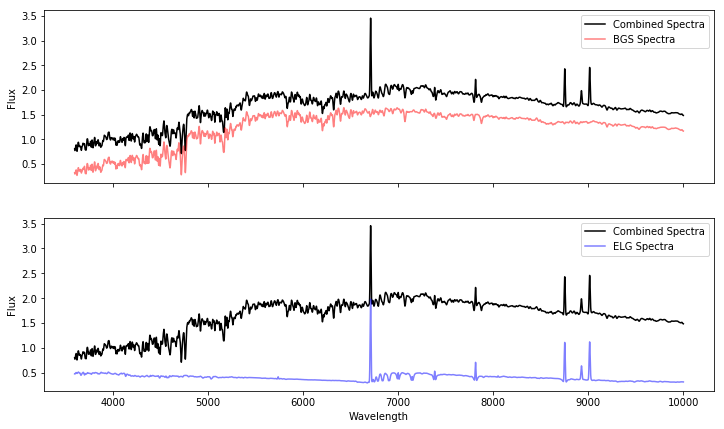

In [5]:
i = 1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 7), sharex=True)

ax1.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax1.plot(combwave, BGSflux[i], 'r-', label='BGS Spectra', alpha=0.5)
ax1.set_ylabel('Flux')
ax1.legend()

ax2.plot(combwave, combflux[i], 'k-', label='Combined Spectra')
ax2.plot(combwave, ELGflux[i], 'b-', label='ELG Spectra', alpha=0.5)
ax2.set_ylabel('Flux')
ax2.set_xlabel('Wavelength')
ax2.legend()

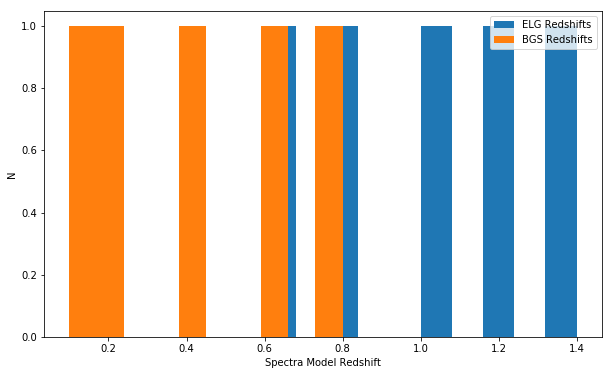

In [6]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.hist(ELGmeta['REDSHIFT'], label='ELG Redshifts')
ax.hist(BGSmeta['REDSHIFT'], label='BGS Redshifts')
ax.set_xlabel('Spectra Model Redshift')
ax.set_ylabel('N')
ax.legend()

## Find Best Redshift and Redrock Models with given redshift

In [7]:
rroutfile = os.path.join(fileloc, 'rr-comb-data')
rrh5file = os.path.join(fileloc, 'rr-comb-outfile.h5')

cmd = 'rrdesi {} -o {} -z {}'.format(outfile, rrh5file, rroutfile)

chkfile(cmd, rrh5file, overwrite=False)

zbest = Table.read(rroutfile, 'ZBEST')
zbest['dz'] = BGSrshifts - zbest['Z']
zbest['realz'] = BGSrshifts
    
tempfile = redrock.templates.find_templates()[0]
rrtemp = redrock.templates.Template(tempfile, wave=combwave)

tempflux = []
tempwave = []

for ii in range(len(zbest)):
    ncoeff = rrtemp.flux.shape[0]
    coeff = zbest['COEFF'][ii][:ncoeff]

    tempflux.append(rrtemp.flux.T.dot(coeff))
    tempwave.append(rrtemp.wave * (1+zbest[ii]['Z']))

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


target 0 id 1 znum 0 GALAXY z=0.936


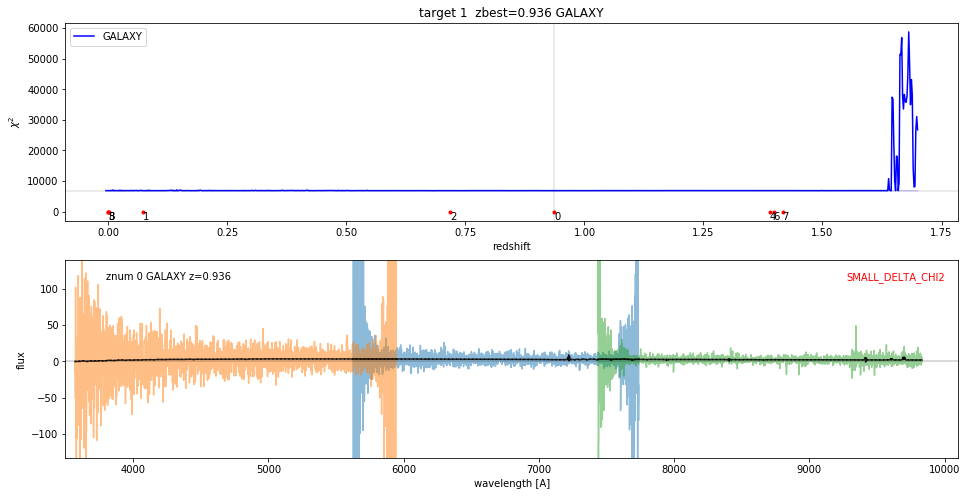

In [8]:
i = 1
templates = {}

z = Table.read(rrh5file, 'zbest')

zscan, zfit = redrock.results.read_zscan(rrh5file)
targets = desi.DistTargetsDESI(outfile, targetids=[z['targetid'][i]])._my_data
templates[rrtemp.full_type] = rrtemp

PlotSpec(targets, templates, {0: zscan}[0], zfit)

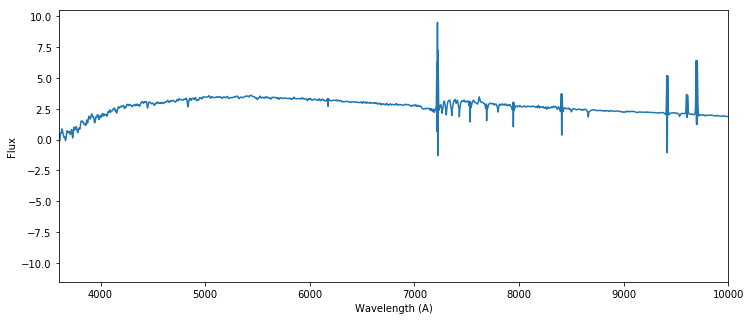

In [9]:
i=1

plotspec(1, tempwave[i], tempflux[i])
#plt.ylim(-10, 5)

"ax[2].plot(zbest['Z'], np.log10(zbest['CHI2']), '.')\nax[2].set_ylabel('log10'r'$(\\chi^2)$')\nax[2].set_xlabel('Redrock Redshift')\n\nax[3].plot(zbest['Z'], zbest['DELTACHI2'], '.')\nax[3].set_ylabel(r'$\\Delta\\chi^2$')\nax[3].set_xlabel('Redrock Redshift')"

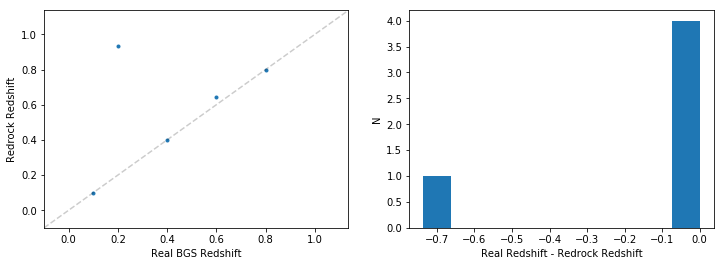

In [10]:
dlim = setlims(BGSrshifts, zbest['Z'])

fig, axs = plt.subplots(1,2,figsize=(12,4)) 

ax = axs.flatten()

ax[0].plot(BGSrshifts, zbest['Z'], '.')
ax[0].set_xlabel('Real BGS Redshift')
ax[0].set_ylabel('Redrock Redshift')
ax[0].set_xlim(dlim)
ax[0].set_ylim(dlim)
ax[0].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.2)

ax[1].hist(zbest['dz'])
ax[1].set_ylabel('N')
ax[1].set_xlabel('Real Redshift - Redrock Redshift')

'''ax[2].plot(zbest['Z'], np.log10(zbest['CHI2']), '.')
ax[2].set_ylabel('log10'r'$(\chi^2)$')
ax[2].set_xlabel('Redrock Redshift')

ax[3].plot(zbest['Z'], zbest['DELTACHI2'], '.')
ax[3].set_ylabel(r'$\Delta\chi^2$')
ax[3].set_xlabel('Redrock Redshift')'''

In [11]:
rrfail = np.where(np.abs(zbest['dz']) > 0.003)[0]
BGSfailrate = len(zbest[rrfail]) / len(zbest)

print('{}% Failure Rate'.format(BGSfailrate*100))
print()
zbest['TARGETID', 'Z', 'realz', 'dz'][rrfail]

40.0% Failure Rate



TARGETID,Z,realz,dz
int64,float64,float64,float64
1,0.9364759223063119,0.2,-0.736475922306312
3,0.6412896167769868,0.6,-0.04128961677698684


## Find Residual Background ELG Redshift with given redshift

In [12]:
specfiles = rrtemp_to_spectra(infile=outfile, nrshifts=len(BGSrshifts), tempfluxes=tempflux, tempwaves=tempwave)

reszbests = []
resh5files = []

for filenum in range(len(specfiles)):
    
    rrsuboutfile = os.path.join(fileloc, 'rr-rerun-subtracted-{}'.format(filenum))
    rrresh5file = os.path.join(fileloc, 'rr-residual-h5-{}'.format(filenum))
    
    cmd = 'rrdesi {} -o {} -z {}'.format(specfiles[filenum], rrresh5file, rrsuboutfile)

    chkfile(cmd, rrresh5file, overwrite=False)
    
    reszbest = Table.read(rrsuboutfile, 'ZBEST')
    
    reszbests.append(reszbest)
    resh5files.append(rrresh5file)
    
reszbests = vstack(reszbests)

reszbests['realz'] = ELGrshifts
reszbests['fratio'] = [.015, .015, .015, .015, .015]
reszbests['dz'] = ELGrshifts - reszbests['Z']

In [20]:
tempwave

[array([ 1350.56360472,  1350.67357918,  1350.78355365, ...,
        12096.93839678, 12097.04837125, 12097.15834571]),
 array([ 2378.12832564,  2378.32197323,  2378.51562082, ...,
        21300.79009564, 21300.98374323, 21301.17739082]),
 array([ 1719.53811048,  1719.67813001,  1719.81814954, ...,
        15401.82670456, 15401.96672409, 15402.10674362]),
 array([ 2015.61882762,  2015.78295658,  2015.94708554, ...,
        18053.80857588, 18053.97270484, 18054.1368338 ]),
 array([ 2210.36555149,  2210.5455384 ,  2210.72552531, ...,
        19798.14635705, 19798.32634396, 19798.50633087])]

In [14]:
reszbests['Z', 'realz', 'dz']

Z,realz,dz
float64,float64,float64
0.47977319768363685,0.6,0.12022680231636312
0.0727753209130724,0.8,0.7272246790869277
0.0018629442404476657,1.0,0.9981370557595524
0.030602531929476588,1.2,1.1693974680705235
0.06312063237902547,1.4,1.3368793676209745


"ax[2].plot(reszbests['Z'], reszbests['DELTACHI2'], '.')\nax[2].set_xlabel('Redrock Redshift')\nax[2].set_ylabel(r'$\\Delta\\chi^2$')\n\nax[3].plot(reszbests['Z'], np.log10(reszbests['CHI2']), '.')\nax[3].set_xlabel('Redrock Redshift')\nax[3].set_ylabel(r'$log_{10}(\\chi^2)$')"

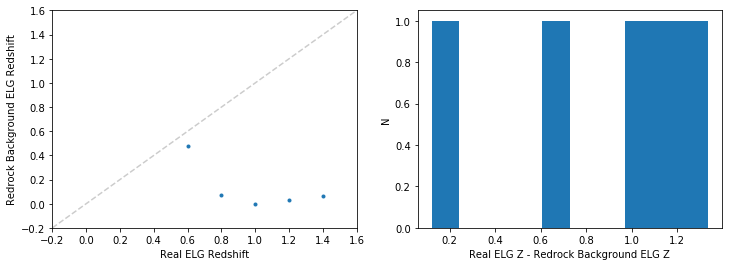

In [15]:
dlim = setlims(ELGrshifts, reszbests['Z'])

fig, axs = plt.subplots(1,2,figsize=(12,4))

ax = axs.flatten()

ax[0].plot(ELGrshifts, reszbests['Z'], '.')
ax[0].set_xlim(dlim)
ax[0].set_ylim(dlim)
ax[0].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.2)
ax[0].set_xlabel('Real ELG Redshift')
ax[0].set_ylabel('Redrock Background ELG Redshift')

ax[1].hist(reszbests['dz'])
ax[1].set_ylabel('N')
ax[1].set_xlabel('Real ELG Z - Redrock Background ELG Z')

'''ax[2].plot(reszbests['Z'], reszbests['DELTACHI2'], '.')
ax[2].set_xlabel('Redrock Redshift')
ax[2].set_ylabel(r'$\Delta\chi^2$')

ax[3].plot(reszbests['Z'], np.log10(reszbests['CHI2']), '.')
ax[3].set_xlabel('Redrock Redshift')
ax[3].set_ylabel(r'$log_{10}(\chi^2)$')'''

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
target 0 id 0 znum 0 GALAXY z=0.480


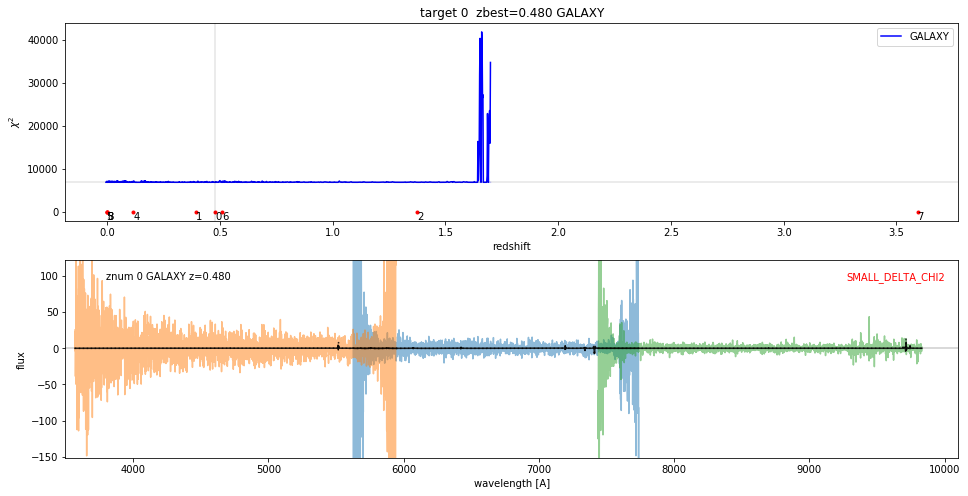

In [16]:
h5data = []
templates = {}
i = 0

for file in resh5files:
    z = Table.read(file, 'zbest')
    h5data.append(z)

h5data = vstack(h5data)

zscan, zfit = redrock.results.read_zscan(resh5files[i])

ELGtempfile = redrock.templates.find_templates()[0]
ELGrrtemp = redrock.templates.Template(ELGtempfile, wave=combwave, spectype='GALAXY')
targets = desi.DistTargetsDESI(specfiles[i], targetids=h5data['targetid'])._my_data
templates[ELGrrtemp.full_type] = ELGrrtemp
    
PlotSpec(targets, templates, zscan, zfit)

(-10, 20)

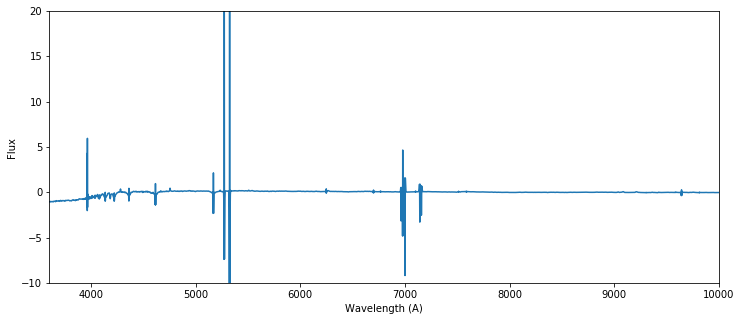

In [17]:
i = 4

ELGtempflux = []
ELGtempwave = []

for ii in range(len(reszbests)):
    nELGcoeff = ELGrrtemp.flux.shape[0]
    ELGcoeff = reszbests['COEFF'][ii][:nELGcoeff]

    ELGtempflux.append(ELGrrtemp.flux.T.dot(ELGcoeff))
    ELGtempwave.append(ELGrrtemp.wave * (1+reszbests[ii]['Z']))

plotspec(1, ELGtempwave[i], ELGtempflux[i])
plt.ylim(-10,20)

In [18]:
rrfail = np.where(np.abs(reszbests['dz']) > 0.003)[0]
ELGfailrate = len(reszbests[rrfail]) / len(reszbests)

print('{}% Failure Rate'.format(ELGfailrate*100))
print()
reszbests['TARGETID', 'Z', 'realz', 'dz'][rrfail]

100.0% Failure Rate



TARGETID,Z,realz,dz
int64,float64,float64,float64
0,0.47977319768363685,0.6,0.12022680231636312
1,0.0727753209130724,0.8,0.7272246790869277
2,0.0018629442404476657,1.0,0.9981370557595524
3,0.030602531929476588,1.2,1.1693974680705235
4,0.06312063237902547,1.4,1.3368793676209745
